#  XPCS   SAXS Pipeline 

 "This notebook corresponds to version {{ version }} of the pipeline tool: https://github.com/NSLS-II/pipelines"

## NSLS2 data retrieval imports

In [1]:
from databroker import DataBroker as db, get_images, get_table, get_events, get_fields
from filestore.api import register_handler, deregister_handler
#from filestore.retrieve import _h_registry, _HANDLER_CACHE, HandlerBase
from eiger_io.pims_reader import EigerImages
from chxtools import handlers

## Import all the required packages for  Data Analysis

#* scikit-beam - data analysis tools for X-ray science 
#    - https://github.com/scikit-beam/scikit-beam
#* xray-vision - plotting helper functions for X-ray science
#    - https://github.com/Nikea/xray-vision

import xray_vision
import xray_vision.mpl_plotting as mpl_plot  
from xray_vision.mpl_plotting import speckle
from xray_vision.mask.manual_mask import ManualMask

import skbeam.core.roi as roi
import skbeam.core.correlation as corr
import skbeam.core.utils as utils

import numpy as np
from datetime import datetime
import h5py

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
%matplotlib notebook
#%matplotlib inline

/opt/conda_envs/analysis/lib/python3.4/site-packages/filestore/retrieve.py:15: UserWarning: Do not import filestore.retrieve, import filestore.api instead
  warnings.warn("Do not import filestore.retrieve, "


### Get the events from the uid

In [2]:
uid = '53b84188'

hdr = db[uid]

In [7]:
#detector = 'eiger_4M_cam_img_image_lightfield'  #for old eiger images before Jan 30, 2016
#detector = 'eiger4m_image'  #for new eiger images after Jan 30, 2016
detector =  list( hdr['descriptors'][0]['data_keys'].keys() )[0]
print (detector)

eiger4m_single_image


In [8]:
#print ( hdr )

In [9]:
flag =1
while flag<4 and flag !=0:    
    try:
        ev, = get_events(hdr, [detector]) 
        flag =0 
    except:
        flag += 1        
        print ('Trying again ...!')
        

hdf5 path = /XF11ID/data/2016/02/24/87d626b2-71d5-4e19-9b80_86_master.h5


In [10]:
from datetime import datetime
dt =datetime.now()
CurTime = '%s%02d%02d-%02d%02d' % (dt.year, dt.month, dt.day,dt.hour,dt.minute)

In [11]:
#dt = datetime.fromtimestamp(hdr['start'].time)
#path ='/XF11ID/analysis' + '/%s/%s/%s/' % (dt.year, dt.month, dt.day)
path = '/XF11ID/analysis/2016_1/Commissioning/Results/'
print ("The analysis results will be saved in : %s"%path)

The analysis results will be saved in : /XF11ID/analysis/2016_1/Commissioning/Results/


In [12]:
imgs = ev['data'][detector]
print (imgs)
Nimg=len(imgs)

<Frames>
Length: 3600 frames
Frame Shape: 2167 x 2070
Pixel Datatype: uint32


## Note:  experiment information 

* The physical size of the pixels
* Wavelegth of the X-rays  - (units in Angstroms)
* Detector to sample distance
* Exposure time - (units in seconds)
* acqusition period - (units in seconds)
* dead time - (units in seconds)
* time per frame = (exposure time + dead_time or acqusition period) - (units in seconds)

In [13]:
imgs.md

{'beam_center_x': 852.0,
 'beam_center_y': 1830.0,
 'count_time': 0.5,
 'detector_distance': 4.8400002,
 'frame_time': 1.00001,
 'incident_wavelength': 1.3776,
 'x_pixel_size': 7.5000004e-05,
 'y_pixel_size': 7.5000004e-05}

In [14]:
# The physical size of the pixels
dpix = imgs.md['x_pixel_size'] * 1000.  
lambda_ = imgs.md['incident_wavelength']    # wavelegth of the X-rays in Angstroms
Ldet = 4840        # detector to sample distance (mm)

exposuretime= imgs.md['count_time']
acquisition_period = imgs.md['frame_time']

# deadtime= 0   # 60e-6 
# timeperframe = exposuretime + deadtime
timeperframe = acquisition_period  

timeperframe, exposuretime

(1.00001, 0.5)

## load a mask if exist 
### otherwise create a mask using Mask pipeline

In [15]:
#mask = np.load(uid+"_mask.npy")
#mask = np.load( path +  str(uid)+"_mask.npy")

#mask = np.load( '/XF11ID/analysis/2016/2/' +  '_sandro'+"_mask_05.npy" )
mask = np.load(    path +   'corapor'+"_mask.npy" )

## Plot the mask

In [16]:
#%matplotlib notebook

<IPython.core.display.Javascript object>


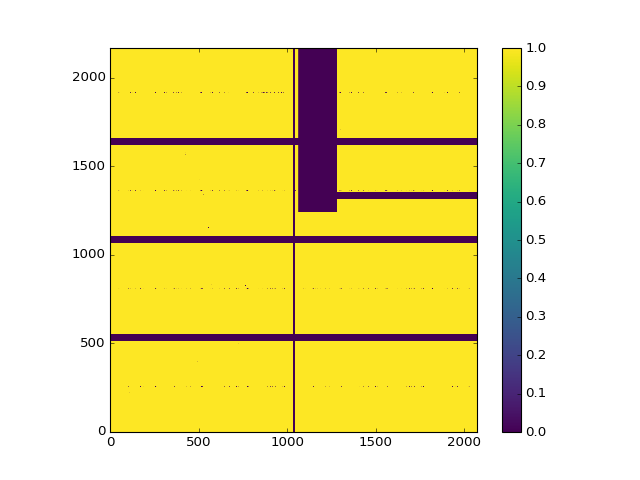

In [17]:
fig, ax = plt.subplots()
im=ax.imshow(mask, origin='lower' ,vmin=0,vmax=1,cmap='viridis')
fig.colorbar(im)
plt.show()

## Interactive way to browse through images.

### Note : Provide the number of images that you want to browse

### hey, let's see if any images are bad!

In [18]:
bin_img = 50
imgsum = [np.sum(img *mask) for img in imgs[::bin_img]]

<IPython.core.display.Javascript object>


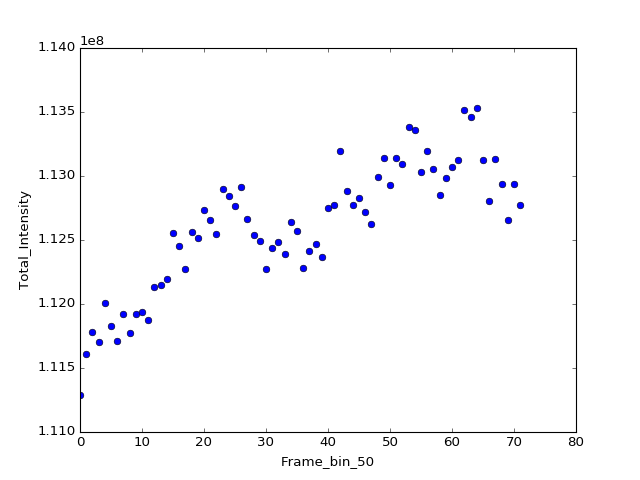

In [19]:
fig, ax = plt.subplots()  
ax.plot(imgsum,'bo')
ax.set_xlabel( 'Frame_bin_%s'%bin_img )
ax.set_ylabel( 'Total_Intensity' )
plt.show()

### Get the Averaged Image Data

In [20]:
avg_img = np.average(imgs[::int(Nimg/100)], axis=0)*mask

## Plot the averged image with the mask

<IPython.core.display.Javascript object>


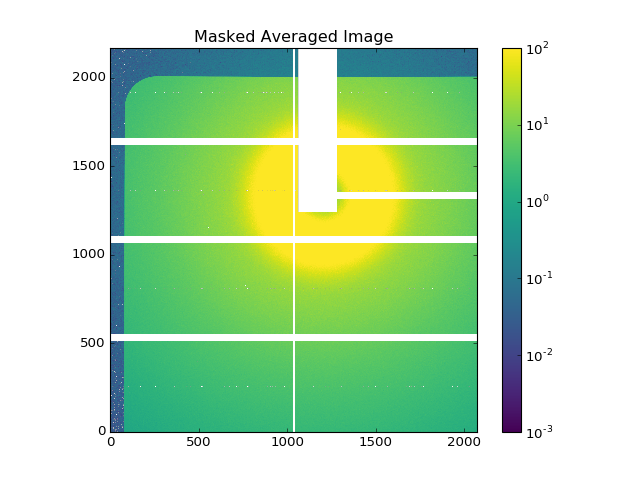

In [21]:
img_mask = avg_img * mask

fig, ax = plt.subplots()
im = ax.imshow(img_mask, cmap='viridis',origin='lower',
               norm= LogNorm(vmin=0.001, vmax=1e2))
ax.set_title("Masked Averaged Image")
fig.colorbar(im)
plt.show()

## Import all the required packages for  Data Analysis

* scikit-beam - data analysis tools for X-ray science 
    - https://github.com/scikit-beam/scikit-beam
* xray-vision - plotting helper functions for X-ray science
    - https://github.com/Nikea/xray-vision


In [22]:
import xray_vision
import xray_vision.mpl_plotting as mpl_plot  
from xray_vision.mpl_plotting import speckle
from xray_vision.mask.manual_mask import ManualMask

import skbeam.core.roi as roi

import skbeam.core.correlation as corr
import skbeam.core.utils as utils

## Get the approximate center and see the statistic to make sure 

In [23]:
imgs.md['beam_center_x'], imgs.md['beam_center_y']

(852.0, 1830.0)

In [24]:

center = [1060, 1958]  # center of the speckle pattern

center = [1202, 1332]  # center of the speckle pattern

#center = [860, 958]  # center of the speckle pattern
center=[center[1], center[0]]

center

[1332, 1202]

### Circular Average : compute the radial integartion from the center of the speckle pattern

In [25]:
bin_centers, ring_averages= roi.circular_average(img_mask, 
        center, threshold=0, nx=1500, pixel_size=(dpix, dpix))

#  convert to q (reciprocal space)
two_theta = utils.radius_to_twotheta(Ldet, bin_centers)
q_val = utils.twotheta_to_q(two_theta, lambda_)

In [26]:
#from chxtools import develop as dev

In [27]:
#cd /XF11ID/analysis/Analysis_Pipelines/Develop/
#%run develop.py
#bin_centers, ring_averages= circular_average(avg_img,  center, 
#                                        pixel_size=(dpix, dpix), mask= mask)

#  convert to q (reciprocal space)
#two_theta = utils.radius_to_twotheta(Ldet, bin_centers)
#q_val = utils.twotheta_to_q(two_theta, lambda_)

<IPython.core.display.Javascript object>


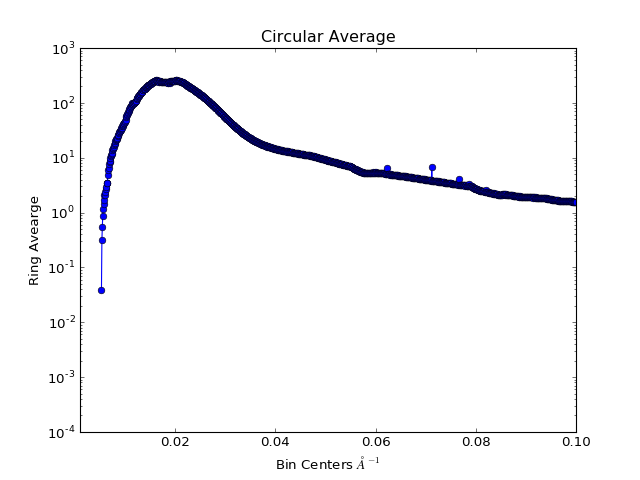

In [28]:
fig,axes = plt.subplots(figsize=(8, 6))
axes.semilogy(q_val, ring_averages, '-o')
axes.set_title('Circular Average')
axes.set_ylabel('Ring Avearge')
axes.set_xlabel('Bin Centers 'r'$\AA^{-1}$')
axes.set_xlim(0.001, 0.1)
axes.set_ylim(0.0001, 1000)
plt.show()

<IPython.core.display.Javascript object>


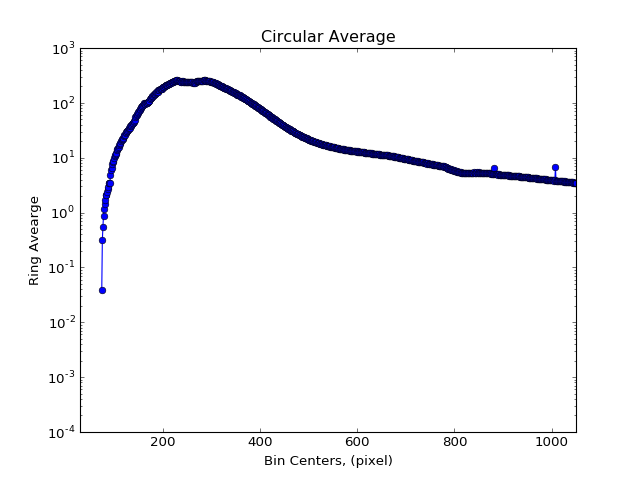

In [29]:
fig,axes = plt.subplots(figsize=(8, 6))
axes.semilogy(bin_centers/dpix, ring_averages, '-o')
axes.set_title('Circular Average')
axes.set_ylabel('Ring Avearge')
axes.set_xlabel('Bin Centers, (pixel)')
axes.set_xlim(30,  1050)
axes.set_ylim(0.0001, 1000)
plt.show()

## Create label array (Q rings)

In [31]:


inner_radius = 120  # radius of the first ring
outer_radius = 800  # radius of the last ring
width = 3      # width of each ring
num_rings = 12   # number of rings

spacing =  (outer_radius - inner_radius)/(num_rings-1) - 2    # spacing between rings


#  find the edges of the required rings
edges = roi.ring_edges(inner_radius, width, spacing, num_rings)
edges

array([[ 120.        ,  123.        ],
       [ 182.81818182,  185.81818182],
       [ 245.63636364,  248.63636364],
       [ 308.45454545,  311.45454545],
       [ 371.27272727,  374.27272727],
       [ 434.09090909,  437.09090909],
       [ 496.90909091,  499.90909091],
       [ 559.72727273,  562.72727273],
       [ 622.54545455,  625.54545455],
       [ 685.36363636,  688.36363636],
       [ 748.18181818,  751.18181818],
       [ 811.        ,  814.        ]])

In [32]:
two_theta = utils.radius_to_twotheta(Ldet, edges*dpix)
q_ring_val = utils.twotheta_to_q(two_theta, lambda_)

q_ring_center = np.average(q_ring_val, axis=1)
q_ring_center

array([ 0.00858714,  0.01302685,  0.01746654,  0.02190619,  0.0263458 ,
        0.03078535,  0.03522483,  0.03966424,  0.04410356,  0.04854279,
        0.05298192,  0.05742093])

In [33]:
rings = roi.rings(edges, center, avg_img.shape)

ring_mask = rings*mask

## Extract the labeled array

In [34]:
labels, indices = roi.extract_label_indices(ring_mask)

## Number of pixels in each q ring

In [35]:
nopr = np.bincount( np.array(labels, dtype=int) )[1:]
nopr

array([ 1033,  2500,  3193,  4514,  5512,  6770,  7968,  9245, 10422,
       11563, 12968, 12744])

# check center

<IPython.core.display.Javascript object>


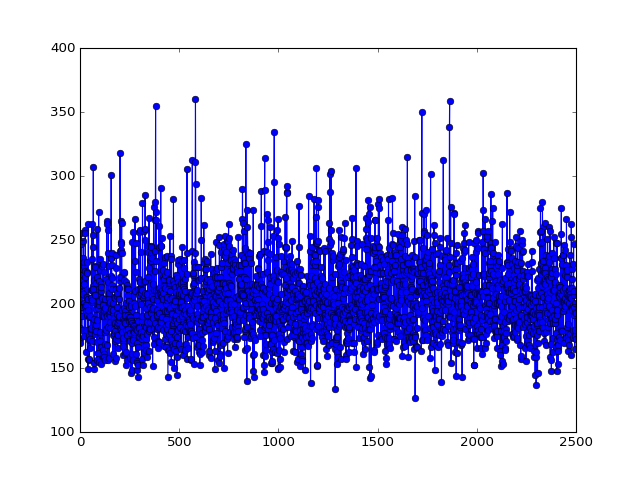

In [36]:
pixel = roi.roi_pixel_values(avg_img*mask, ring_mask, [2] )
fig, ax = plt.subplots()
ax.plot( pixel[0][0] ,'bo', ls='-' )
plt.show()

In [37]:
%matplotlib notebook

<IPython.core.display.Javascript object>


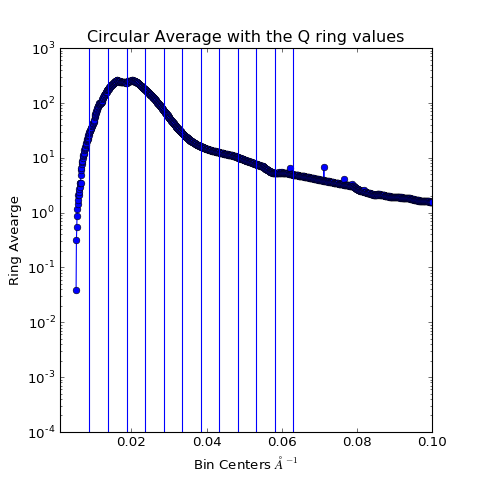

In [54]:
fig, axes = plt.subplots( figsize=(6, 6))
axes.semilogy(q_val, ring_averages, '-o')
#axes.plot(q_val, ring_averages, '-o')
axes.set_title('Circular Average with the Q ring values')
axes.set_ylabel('Ring Avearge')
axes.set_xlabel('Bin Centers 'r'$\AA^{-1}$')
#axes.set_xlim(0, 0.02)
axes.set_xlim(0.001, 0.1)
axes.set_ylim(0.0001, 1000)
#axes.set_ylim(0, 100)
for i in range(num_rings):
    axes.axvline(q_ring_center[i])
plt.show()

## To mask the each image

In [38]:
class Masker(object):
    def __init__(self, indexable, mask):
        self.indexable = indexable
        self.mask = mask
    def __getitem__(self, key):
        return self.indexable[key] * mask

In [39]:
masker = Masker(imgs, mask)

<IPython.core.display.Javascript object>


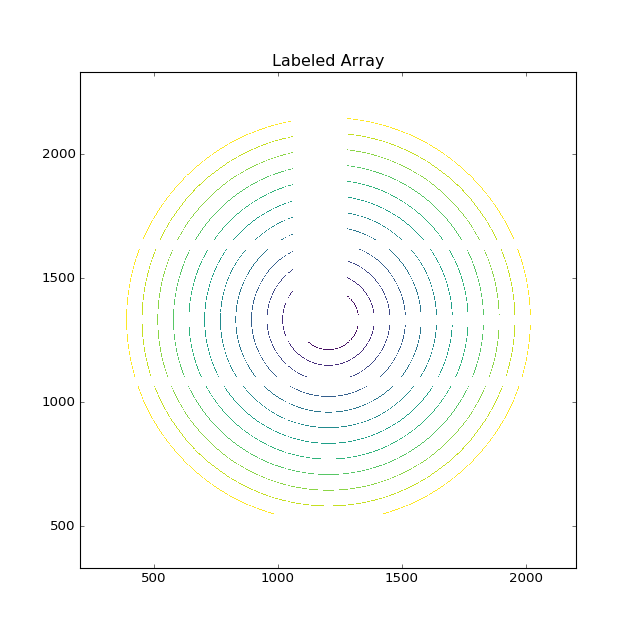

(332, 2332)

In [40]:
# plot the figure
fig, axes = plt.subplots(figsize=(8,8))
axes.set_title("Labeled Array")
im = mpl_plot.show_label_array(axes, ring_mask, cmap='viridis',origin='lower')

rwidth = 1000 

x1,x2 = [center[1] - rwidth, center[1] + rwidth]
y1,y2 = [center[0] - rwidth, center[0] + rwidth]
axes.set_xlim( [x1,x2])
axes.set_ylim( [y1,y2])


##  Kymograph(waterfall plot) of a ring

In [512]:
#kymo = roi.kymograph(masker[::50], ring_mask, num = 4)  # eg: num=4 , 4th ring

In [40]:
#fig, ax = plt.subplots(figsize=(6,8))
#ax.set_ylabel('Pixel')
#ax.set_xlabel('Frame')
#ax.set_title('Kymograph')

#im = ax.imshow(kymo.T, cmap='viridis', vmax=100)
#fig.colorbar( im   )
#ax.set_aspect(0.05)
#plt.show()

##  Mean intensities for each ring

In [41]:
mask_data = masker[::int(Nimg/50)]  #this one is too slow if make  masker[::1]
mean_int_sets, index_list = roi.mean_intensity(mask_data, ring_mask)

In [69]:
#%matplotlib notebook

<IPython.core.display.Javascript object>


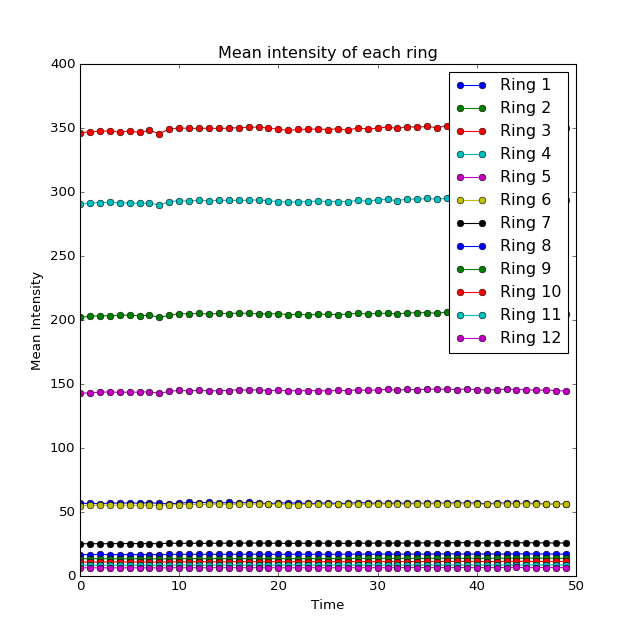

In [42]:
time = np.arange(len(mask_data))*timeperframe  # get the time for each frame


fig, ax = plt.subplots(figsize=(8, 8))
ax.set_title("Mean intensity of each ring")
for i in range(num_rings):
    ax.plot(time, mean_int_sets[:,i], label="Ring "+str(i+1),marker = 'o', ls='-')
    ax.set_xlabel("Time")
    ax.set_ylabel("Mean Intensity")
ax.legend() 
plt.show()

## One time Correlation

Note : Enter the number of levels and number of buffers for Muliti tau one time correlation
number of buffers has to be even. More details in https://github.com/scikit-beam/scikit-beam/blob/master/skbeam/core/correlation.py

In [43]:
ring_mask = np.array(ring_mask, dtype=int)

In [44]:
imgs

<Frames>
Length: 3600 frames
Frame Shape: 2167 x 2070
Pixel Datatype: uint32

In [45]:
imgs_ = imgs[10:Nimg]
noframes = len( imgs_)

In [46]:
#num_lev = 12  # number of levels
num_buf = 8  # number of buffers
num_lev = int(np.log( noframes/(num_buf-1))/np.log(2) +1) +1
print ('In this g2 calculation, the buf and lev number are: %s--%s--'%(num_buf,num_lev))
print ('%s frames will be processed...'%(noframes))


In this g2 calculation, the buf and lev number are: 8--11--
3590 frames will be processed...


In [47]:
g2, lag_steps = corr.multi_tau_auto_corr(num_lev, num_buf,   ring_mask, imgs_)

In [523]:
#corr.lazy_one_time??

In [48]:
%matplotlib inline

### Plot the one time correlation functions

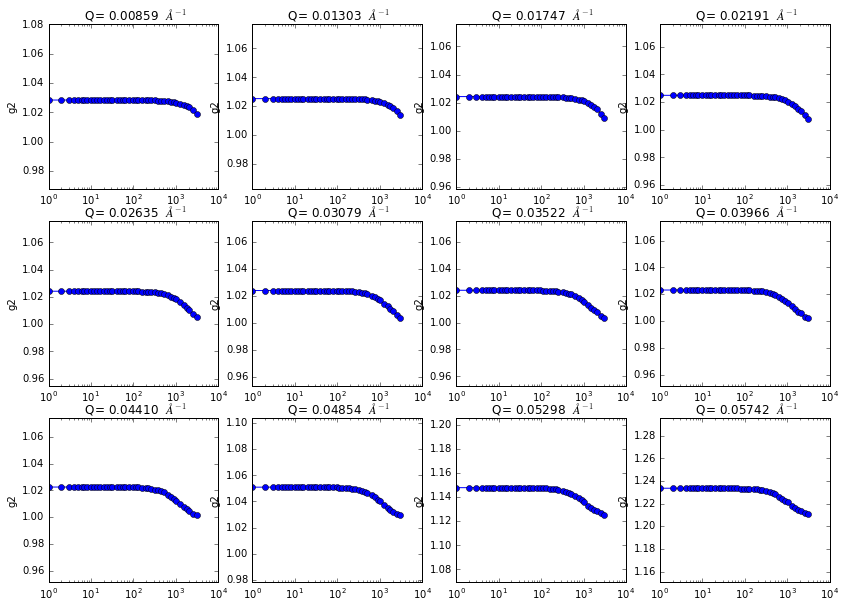

In [49]:
lags = lag_steps*timeperframe

sx = int(round(np.sqrt(num_rings)) )
if num_rings%sx == 0: 
    sy = int(num_rings/sx)
else:
    sy=int(num_rings/sx+1)
fig = plt.figure(figsize=(14, 10))
plt.title('uid= %s'%uid,fontsize=20, y =1.02)
plt.axes(frameon=False)
plt.xticks([])
plt.yticks([])
for i in range(num_rings):
    ax = fig.add_subplot(sx, sy, i+1 )
    ax.set_ylabel("g2") 
    ax.set_title(" Q= " + '%.5f  '%(q_ring_center[i]) + r'$\AA^{-1}$')
    y=g2[:, i]
    ax.semilogx(lags, y, '-o', markersize=6) 
    ax.set_ylim([min(y)*.95, max(y[1:])*1.05 ])
plt.show()
fig.tight_layout()  

# Fit g2

In [50]:
#%matplotlib inline

In [51]:
def stretched_auto_corr_scat_factor(lags, beta, relaxation_rate, alpha, baseline=1):
    return beta * (np.exp(-2 * relaxation_rate * lags))**alpha + baseline

In [52]:
from lmfit import  Model
mod = Model(corr.auto_corr_scat_factor)
mods = Model(stretched_auto_corr_scat_factor)

## using a simple exponential model to fit data

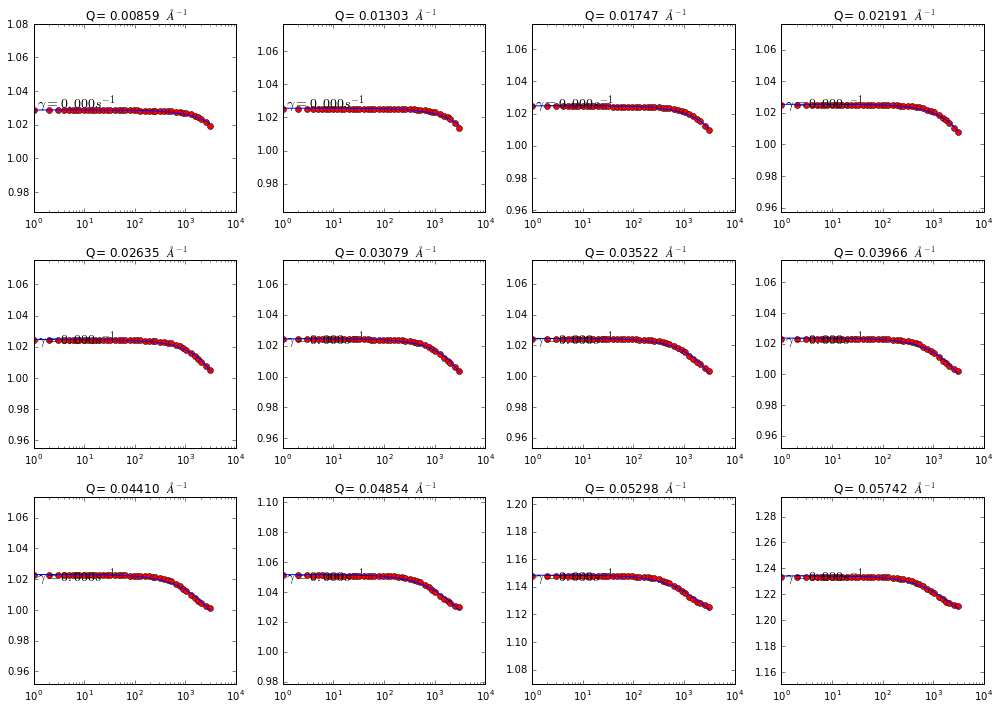

In [53]:
rate = []  #  relaxation rate

sx = int( round (np.sqrt(num_rings)) )
if num_rings%sx==0:
    sy = int(num_rings/sx)
else:
    sy = int(num_rings/sx+1)
    
fig = plt.figure(figsize=(14, 10))
plt.title('uid= %s'%uid, fontsize=20, y =1.02) 
plt.axes(frameon=False)
plt.xticks([])
plt.yticks([])
for i in range(num_rings):
    ax = fig.add_subplot(sx, sy, i+1 )
    y=g2[1:, i]
    result1 = mod.fit(y, lags=lags[1:], beta=.1,
                      relaxation_rate =.5, baseline=1.0)
    rate.append(result1.best_values['relaxation_rate'])
    
    ax.semilogx(lags[1:], y, 'ro')
    ax.semilogx(lags[1:], result1.best_fit, '-b')
    ax.set_title(" Q= " + '%.5f  '%(q_ring_center[i]) + r'$\AA^{-1}$')  
    ax.set_ylim([min(y)*.95, max(y[1:]) *1.05])
    txts = r'$\gamma$' + r'$ = %.3f$'%(rate[i]) +  r'$ s^{-1}$'
    ax.text(x =0.015, y=.55, s=txts, fontsize=14, transform=ax.transAxes)              
fig.tight_layout()  
plt.show()

## using a streched exponential model to fit data

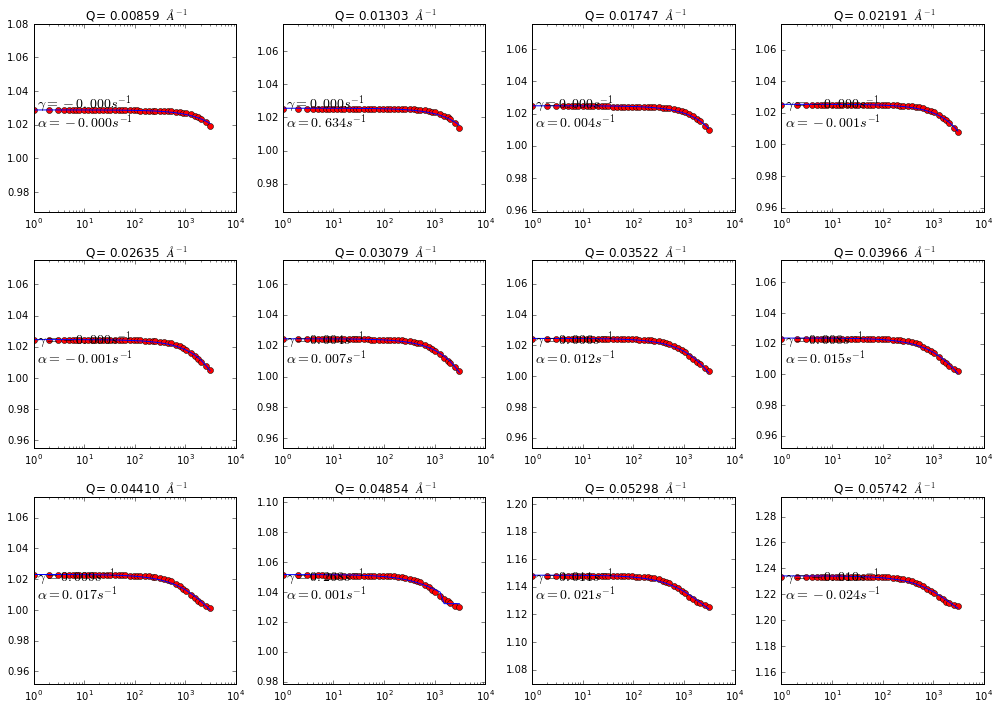

In [54]:
rates = []  #  relaxation rate
alphas = []  #  relaxation rate

sx = int( round (np.sqrt(num_rings)) )
if num_rings%sx==0:
    sy = int(num_rings/sx)
else:
    sy = int(num_rings/sx+1)
    
fig = plt.figure(figsize=(14, 10))
plt.title('uid= %s'%uid, fontsize=20, y =1.02) 
plt.axes(frameon=False)
plt.xticks([])
plt.yticks([])
for i in range(num_rings):
    ax = fig.add_subplot(sx, sy, i+1 )
    y=g2[1:, i]
    result1 = mods.fit(y, lags=lags[1:], beta=.1,
                      relaxation_rate =.5, alpha=1., baseline=1.0)
    rates.append(result1.best_values['relaxation_rate'])
    alphas.append( result1.best_values['alpha'] )
    
    ax.semilogx(lags[1:], y, 'ro')
    ax.semilogx(lags[1:], result1.best_fit, '-b')
    ax.set_title(" Q= " + '%.5f  '%(q_ring_center[i]) + r'$\AA^{-1}$')  
    ax.set_ylim([min(y)*.95, max(y[1:]) *1.05])
    txts = r'$\gamma$' + r'$ = %.3f$'%(rates[i]) +  r'$ s^{-1}$'    
    ax.text(x =0.015, y=.55, s=txts, fontsize=14, transform=ax.transAxes) 
    
    txts = r'$\alpha$' + r'$ = %.3f$'%(alphas[i]) +  r'$ s^{-1}$'    
    ax.text(x =0.015, y=.45, s=txts, fontsize=14, transform=ax.transAxes) 
    
fig.tight_layout()  
plt.show()

In [55]:
rate

[3.5601418524203204e-08,
 2.5606797297149114e-08,
 3.4256620723009614e-08,
 3.5729675597598396e-08,
 6.6848159655106265e-08,
 2.6825231401213175e-05,
 7.5362117220936341e-05,
 0.00011537398856682479,
 0.00015705859812824527,
 0.00018744457043935099,
 0.00022547696065764095,
 0.00023578361451339201]

In [56]:
result1.best_values

{'alpha': -0.023592915245210705,
 'baseline': 1.201562059385918,
 'beta': 0.032639787645556667,
 'relaxation_rate': -0.0099933024544214665}

## Plot the relaxation rates vs (q_ring_center)**2

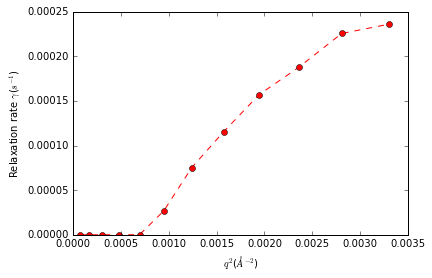

In [57]:
fig, ax = plt.subplots()
ax.plot(q_ring_center**2, rate, 'ro', ls='--')
ax.set_ylabel('Relaxation rate 'r'$\gamma$'"($s^{-1}$)")
ax.set_xlabel("$q^2$"r'($\AA^{-2}$)')
plt.show()

# Fitted the Diffusion Coefficinet D0

In [58]:
D0 = np.polyfit(q_ring_center**2, rate, 1)
gmfit = np.poly1d(D0)
'The fitted diffusion coefficient D0 is:  %.2E'r'($\AA^{-2}$)'%D0[0]

'The fitted diffusion coefficient D0 is:  8.62E-02($\\AA^{-2}$)'

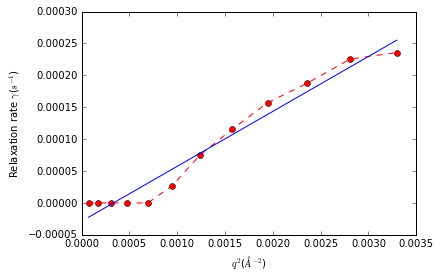

In [59]:
fig, ax = plt.subplots()
ax.plot(q_ring_center**2, rate, 'ro', ls='--')
ax.plot(q_ring_center**2,  gmfit(q_ring_center**2),  ls='-')
ax.set_ylabel('Relaxation rate 'r'$\gamma$'"($s^{-1}$)")
ax.set_xlabel("$q^2$"r'($\AA^{-2}$)')
plt.show()

In [60]:
bad_image_process = False

## If  Bad Images Involved

In [61]:
if bad_image_process:

    import skbeam.core.mask as mask
    bad_img_list = [2, 30, 206, 300, 405]
    new_imgs = mask.bad_to_nan_gen(imgs, bad_img_list)
    g2_n, lag_steps_n = corr.multi_tau_auto_corr(num_lev, num_buf,  ring_mask, new_imgs)
    

In [62]:
if bad_image_process:

    lags_n = lag_steps_n*timeperframe

    sx = int(round(np.sqrt(num_rings)) )
    if num_rings%sx == 0: 
        sy = int(num_rings/sx)
    else:
        sy=int(num_rings/sx+1)
    fig = plt.figure(figsize=(16, 12))
    plt.title('uid= %s'%uid,fontsize=20, y =1.02)
    plt.axes(frameon=False)
    plt.xticks([])
    plt.yticks([])
    for i in range(num_rings):
        ax = fig.add_subplot(sx, sy, i+1 )
        ax.set_ylabel("g2") 
        ax.set_title(" Q= " + '%.5f  '%(q_ring_center[i]) + r'$\AA^{-1}$')
        y_n = g2_n[:, i]
        ax.semilogx(lags_n, y_n, '-o', markersize=6) 
        ax.set_ylim([min(y_n)*.95, max(y_n[1:])*1.05 ])
    plt.show()
    fig.tight_layout()  